# **Clasificadores híbricos**

Los clasificadores híbridos son modelos de aprendizaje automático que combinan dos o más algoritmos de clasificación diferentes para aprovechar sus fortalezas individuales y mejorar el rendimiento general.

Estos modelos tienen como objetivo lograr una mejor precisión, robustez y generalización integrando múltiples técnicas de aprendizaje.

Los clasificadores híbridos se pueden aplicar a diversas tareas, incluida la pronóstico de series de tiempo, el reconocimiento de imágenes y el procesamiento del lenguaje natural.


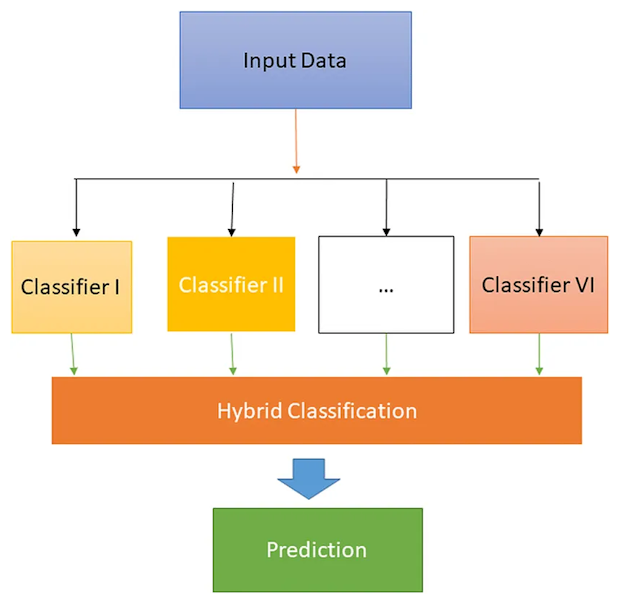


## Tipos de clasificadores híbridos
1. **Clasificadores híbridos secuenciales**:

- En cascada: primero se aplica un modelo, y su salida se utiliza como una función de entrada para el siguiente modelo.
    - Por ejemplo, utilizando un árbol de decisión para manejar la clasificación inicial y luego refinar los resultados con una red neuronal.
- Por etapa: se aplican diferentes modelos en diferentes etapas del proceso de clasificación, cada uno abordando partes específicas del problema.

2. **Clasificadores híbridos paralelos**:
- Métodos de ensemble: múltiples modelos se entrenan de forma independiente y sus predicciones se combinan.Las técnicas comunes incluyen:
- Baggins: capacitar a múltiples modelos en diferentes subconjuntos de los datos y promediar sus predicciones (por ejemplo, bosques aleatorios).
- Boosting: entrenamiento de modelos secuencialmente, cada uno se centra en los errores del anterior (por ejemplo, máquinas de impulso de gradiente, Adaboost).
- Stacking: entrenando modelos base múltiples y luego usando otro modelo (meta-aprendizaje) para combinar sus salidas.

3. **Clasificadores híbridos integrados**:
- Algoritmos híbridos: integrando diferentes algoritmos en un solo modelo.
    - Por ejemplo, combinar árboles de decisión con redes neuronales para formar una red estructurada por árboles donde cada nodo es una pequeña red neuronal.

## Clasificadores híbridos en el pronóstico de series temporales

1. **ARIMA + Modelo ML**:
- ARIMA: captura patrones lineales y estacionalidad.
- Modelo ML (ej, Random Forest, SVM): modela los residuos de la ARIMA para capturar relaciones no lineales.

2. **LSTM + Modelos basados ​​en árboles**:
- LSTM (Long Short-Term Memory): Maneja dependencias secuenciales y patrones a largo plazo.
- Modelos basados ​​en árboles (ej, Random Forest, Gradient Boosting): Refina las predicciones capturando no linealidades e interacciones adicionales.

## Beneficios de los clasificadores híbridos
- Mejjora de precisión: la combinación de diferentes modelos a menudo da como resultado un mejor rendimiento predictivo.
- Robustez: reduce el riesgo de sobreajuste y aumenta la generalización del modelo.
- Flexibilidad: puede manejar diversos tipos de datos y relaciones dentro de los datos.
- Reducción de errores: cada modelo puede abordar las debilidades de los demás, lo que lleva a predicciones más confiables.

## Desafíos y consideraciones
- Complejidad: los modelos híbridos pueden ser más complejos de diseñar, implementar e interpretar.
- Recursos computacionales: a menudo requieren más potencia computacional y tiempo para capacitación y predicción.
- Ajuste del hiperparámetro: encontrar los parámetros óptimos para cada modelo de componente y su combinación puede ser un desafío.

## Implementación paso a paso

1. Cargue y preprocese datos: cargar los datos de la serie temporal y preprocesarlos.
2. Modelo ARIMA: ajustar un modelo ARIMA para capturar tendencias lineales y estacionalidad.
3. Cálculo residual: Calcular los residuos del modelo ARIMA.
4. Ingeniería de características: Crear características rezagadas y estadísticas continuas de los residuos.
5. Modelo de bosque aleatorio: Ajustar un modelo de bosque aleatorio a los residuos utilizando las características de ingeniería.
6. Combine las predicciones: Agregar las predicciones ARIMA a las predicciones del bosque aleatorio para obtener el pronóstico final.
7. Evaluación: evaluar el rendimiento del modelo híbrido.

## Ejemplo

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tabulate import tabulate

In [ ]:
# Paso 1: Cargar y preprocesar datos
data = pd.Series(np.random.randn(1000), index=pd.date_range(start='2020-01-01', periods=1000, freq='D'))

print('data:\n',data[:5])

# División de prueba de tren
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]


In [ ]:
# Paso 2: Ajustar ARIMA a los datos de entrenamiento
arima_model = ARIMA(train, order=(5, 1, 0))
arima_fit = arima_model.fit()

# Predecir con el modelo ARIMA
arima_pred = arima_fit.forecast(steps=len(test))

In [ ]:
# Paso 3: Calcular los residuos en los datos de entrenamiento
residuals = train - arima_fit.fittedvalues

print(residuals[:5])

In [ ]:
# Paso 4: Ingeniería de características en residuos
def create_features(data, lags):
    features = pd.DataFrame(index=data.index)
    for lag in range(1, lags + 1):
        features[f'lag_{lag}'] = data.shift(lag)
    features.dropna(inplace=True)
    return features


lags = 5

train_features = create_features(residuals, lags)
train_labels = residuals.iloc[lags:]

print('train_features:\n', train_features[:5])

print('\ntrain_labels:\n', train_labels[:5])

In [ ]:
# Paso 5: Ajustar bosque aleatorio en residuos
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_features, train_labels)

In [ ]:
# Paso 6: datos de prueba y generar predicciones
test_residuals = test - arima_pred
test_features = create_features(pd.concat([residuals[-lags:], test_residuals]), lags)
test_features = test_features[-len(test):]  # Alinearse con la longitud del conjunto de pruebas

# Predecir los residuos con bosque aleatorio
rf_pred_residuals = rf_model.predict(test_features)

# Combinar predicciones ARIMA con predicciones residuales de RF
final_pred = arima_pred + rf_pred_residuals

In [ ]:
# Paso 7: evaluar el modelo
mse = mean_squared_error(test, final_pred)
print(f'Mean Squared Error: {mse}')

In [ ]:
# Graficar los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label='Actual')
plt.plot(test.index, arima_pred, label='ARIMA Prediction')
plt.plot(test.index, final_pred, label='Hybrid Prediction')
plt.legend()
plt.show()